### See if you can use neural nets to perform regression like cibersort
Simulate a bunch of RNA data and train a model on it to see if it performs well on deconvolution tasks.
Right now all I can do is generate new samples from existing data and train it on them.

So first what I have to do is reduce the datas dimensionality sufficently so that a large portion of the variance is explained. Then I will fit it to a GMM and generate points. As of right now i have to use the predictions made from cibersort which isnt exactly what I wanted to do but we dont have ground truth data so it wouild be hard to do it any other way.

### Imports

In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import TumorDecon as td
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import mean_absolute_error

### To be made into class for nn_decomposition

In [3]:
def nate_sort(rna_sample, sig_df, nu=0.5, C=1.0, kernel='linear', shrinking=True):
    import numpy as np
    from sklearn.model_selection import GridSearchCV

    # If a numerical of nu not explicitly specified, use gridsearch to find the best nu:
    if nu == 'best':
        
        gridsearch = GridSearchCV(MLPRegressor(solver="lbfgs"), cv=5, param_grid={"learning_rate_init":[.001,.005,.01,.02,.1]}, scoring='neg_mean_squared_error', refit=True, iid=False)
        gridsearch.fit(sig_df, rna_sample)
        lr = gridsearch.best_params_['learning_rate_init']
        

    # Fit nuSVR with best (or specified) value of nu:
    clf = MLPRegressor(solver="lbfgs", learning_rate_init=lr)
    clf.fit(sig_df, rna_sample)

    # Replace negative "frequencies" with 0:
    weights = np.array(clf.coef_)[0] # equivalent to np.matmul(np.array(clf.dual_coef_), np.array(clf.support_vectors_))[0]
    weights[weights<0] = 0
    # Sum to 1 contraint:
    weights = weights / np.sum(weights)

    return weights
def nate_sort_main(rna_df, sig_df, patient_IDs='ALL', args={}):
    for patient in patient_list:
        if patient in rna_df.columns:
            cell_freqs_df[patient] = cibersort(rna_df[patient], sig_df, nu=nu, C=C, kernel=kernel, shrinking=shrinking)
        else:
            raise ValueError("patient_ID ({!r}) not present in rna dataframe".format(patient))
            return
    cell_freqs_df = cell_freqs_df.transpose()
    return cell_freqs_df

### Read Data

In [4]:
df = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/scripts/TumorDecon/data/Simulation_data/Simulation_mixture.csv",index_col="Patient")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
Patient,,,,,,,,,,,,,,,,,,,,,
0,0.041987,0.029400,0.058375,0.065183,0.011434,0.054252,0.051492,0.050393,0.019502,0.050503,...,0.055866,0.048454,0.014117,0.028026,0.063896,0.054038,0.057907,0.041855,0.064365,0.034044
1,0.029913,0.048027,0.008742,0.062388,0.021600,0.041344,0.019164,0.062305,0.065441,0.043912,...,0.078530,0.023266,0.084164,0.035252,0.071408,0.001722,0.065863,0.019781,0.084790,0.037326
2,0.060445,0.002421,0.016912,0.079836,0.073710,0.002900,0.041895,0.037881,0.080806,0.042998,...,0.015474,0.066772,0.047766,0.087620,0.043304,0.087087,0.009160,0.013183,0.049630,0.066232
3,0.062324,0.057795,0.021215,0.018881,0.108848,0.030902,0.038093,0.073227,0.104172,0.040704,...,0.016990,0.021771,0.021409,0.055658,0.071423,0.047555,0.048253,0.046857,0.039450,0.000802
4,0.023462,0.067551,0.033406,0.079458,0.038118,0.005731,0.055723,0.046567,0.057377,0.077398,...,0.011191,0.054797,0.052404,0.009651,0.081185,0.035069,0.074087,0.056898,0.040362,0.001412


In [5]:
df2 = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/scripts/TumorDecon/data/Simulation_data/Simulation_SNR100to5.csv",index_col="Hugo_Symbol")
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
A1CF,189.364311,276.227372,104.267251,28.697054,296.146820,208.322157,343.290502,362.571761,69.765975,108.687679,...,263.371765,0.000000,81.340653,249.694179,329.039262,298.426071,246.263884,183.588010,168.999810,245.678629
A2M,1364.256599,1239.289091,2116.908009,1768.456793,1136.012086,729.338018,1070.376415,841.686383,1606.747140,1354.015708,...,1733.195269,1894.002367,1911.714906,1486.086606,1061.448100,1331.084175,2495.915515,1443.909308,2008.877540,128.430483
A4GALT,0.000000,233.820915,116.652581,312.173105,0.000000,190.201734,51.227503,0.000000,0.000000,230.514764,...,0.000000,0.000000,12.509306,214.052744,35.980749,0.000000,170.408628,0.000000,143.959652,44.448153
A4GNT,284.196389,277.334832,345.413967,458.714968,214.712847,212.083277,182.001453,166.074495,408.083165,286.878666,...,442.743888,0.000000,30.756553,0.000000,495.355076,63.384024,139.374166,413.569199,71.118304,103.270241
AAAS,131.015559,29.684689,131.304606,0.945879,224.295002,140.637259,63.511066,445.517859,37.338367,82.247556,...,99.726423,448.633177,283.418826,47.189144,47.417713,0.000000,205.780367,0.000000,0.000000,166.116612


Goal is to make a thing which looks at the hugo symnbol finds the index and puts the respective number there.

In [6]:
lm22 = td.read_lm22_file()

In [7]:
lm22.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
ABCB4,555.713449,10.744235,7.225819,4.311280,4.605860,7.406442,8.043976,6.469993,7.833082,9.312295,...,6.202496,7.951360,27.557710,121.432277,114.636747,4.872184,4.727985,34.113659,15.030530,14.906888
ABCB9,15.603544,22.094787,653.392328,24.223723,35.671507,30.048192,38.455423,17.604795,46.073657,19.715722,...,20.309426,56.251887,29.380878,40.390260,123.993305,23.384603,53.466757,23.615746,29.786442,33.679147
ACAP1,215.305951,321.621021,38.616872,1055.613378,1790.097170,922.152747,340.883424,1107.798265,1995.482601,280.075719,...,190.879024,48.972217,30.974254,23.055150,61.386550,26.412923,104.200198,73.607932,696.442802,596.025961
ACHE,15.117949,16.648847,22.123737,13.428288,27.187732,18.444927,13.441268,14.805542,24.652712,33.658448,...,16.375268,13.692963,1373.069620,48.585761,16.715474,193.159977,13.948778,20.501249,40.414927,22.766494
ACP5,605.897384,1935.201479,1120.104684,306.312519,744.656599,557.819820,248.546932,711.949744,958.916018,493.969120,...,512.931382,13644.172300,1062.475909,7633.960182,13825.053630,3989.865169,263.497930,323.381277,860.563374,307.142798


### Normalize Data

In [8]:
def encode_inputs(rna_df,sig_df):
    df_temp = td.df_normalization(rna_df,"minmax")
    rna_df_red ,sig_df_red = td.keep_common_genes(df_temp,sig_df)
    df_temp = rna_df_red.T
    return df_temp

In [9]:
v = encode_inputs(df2,lm22)

In [10]:
v.head()

Hugo_Symbol,ABCB4,ABCB9,ACAP1,ACHE,ACP5,ADAM28,ADAMDEC1,ADAMTS3,ADRB2,AIF1,...,ZBTB10,ZBTB32,ZFP36L2,ZNF135,ZNF165,ZNF204P,ZNF222,ZNF286A,ZNF324,ZNF442
0,0.000000,0.008741,0.018700,0.000000,0.065185,0.000000,0.024267,0.000192,0.026440,0.042060,...,0.000682,0.000000,0.028918,0.003554,0.013822,0.002950,0.000000,0.006116,0.001773,0.000000
1,0.004521,0.003642,0.001143,0.003527,0.062989,0.002774,0.028970,0.004364,0.033619,0.054960,...,0.011550,0.006813,0.026780,0.000017,0.018506,0.001911,0.000000,0.009289,0.000000,0.001291
2,0.001469,0.002809,0.017536,0.006876,0.085042,0.012947,0.042777,0.000000,0.016409,0.061512,...,0.014261,0.002745,0.027155,0.000000,0.007718,0.006188,0.000000,0.007140,0.000000,0.000000
3,0.000000,0.002050,0.014800,0.000000,0.066475,0.010734,0.018472,0.003992,0.025128,0.041730,...,0.005809,0.000000,0.025412,0.002140,0.007833,0.000000,0.010934,0.004291,0.000000,0.004756
4,0.003631,0.010059,0.011671,0.006006,0.067268,0.005653,0.031315,0.003654,0.032530,0.030658,...,0.004715,0.006292,0.024645,0.000000,0.006716,0.002526,0.000000,0.006413,0.002199,0.000000


### Generate new data from ground truth data

In [11]:
from sklearn.ensemble import IsolationForest
def generate_data(num_samples, x_df, y_df,n_components=6):
    temp_arr = np.empty([x_df.shape[0]-20,x_df.shape[1]+y_df.shape[1]])
    x_df = x_df.values
    y_df = y_df.values
    for i in range(len(temp_arr)):
        for j in range(len(temp_arr[1])):
            if j < x_df.shape[1]:
                temp_arr[i][j] = x_df[i][j]
            else:
                temp_arr[i][j] = y_df[i][j-x_df.shape[1]]

    bgm = BayesianGaussianMixture(n_components=n_components)
    bgm.fit(temp_arr)
    clf = IsolationForest().fit(temp_arr)
    samples = []
    while len(samples) < num_samples:
        sample = bgm.sample(num_samples-len(samples))[0]
        outliers = clf.predict(sample)
        for i in range(len(outliers)):
            if outliers[i] == 1 or True:
                samples.append(sample[i])
            
    samples = np.asarray(samples)
    sampled_x = samples[:,:x_df.shape[1]]
    sampled_y = samples[:,x_df.shape[1]:]
    return sampled_x, sampled_y

In [12]:
generated_x, generated_y = generate_data(100000, v, df,n_components=80)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


### NN Model

In [13]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(547)),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(22)
    ]
)
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mae','mape'])

In [14]:

#X_train, X_test, y_train, y_test = train_test_split(v.values, df.values, test_size=0.2, random_state=42)

In [15]:
history = model.fit(generated_x, generated_y, epochs=20, 
                    validation_data=(v.values[-20:], df.values[-20:]))

Train on 100000 samples, validate on 20 samples
Epoch 1/20
100000/100000 [==============================] - 10s 104us/sample - loss: 0.0054 - mae: 0.0054 - mape: 13.2342 - val_loss: 0.0167 - val_mae: 0.0167 - val_mape: 176.8498
Epoch 2/20
100000/100000 [==============================] - 9s 94us/sample - loss: 0.0038 - mae: 0.0038 - mape: 9.3096 - val_loss: 0.0169 - val_mae: 0.0169 - val_mape: 171.8932
Epoch 3/20
100000/100000 [==============================] - 9s 92us/sample - loss: 0.0036 - mae: 0.0036 - mape: 8.9155 - val_loss: 0.0169 - val_mae: 0.0169 - val_mape: 176.5556
Epoch 4/20
100000/100000 [==============================] - 9s 91us/sample - loss: 0.0035 - mae: 0.0035 - mape: 8.7366 - val_loss: 0.0168 - val_mae: 0.0168 - val_mape: 168.2779
Epoch 5/20
100000/100000 [==============================] - 9s 92us/sample - loss: 0.0035 - mae: 0.0035 - mape: 8.5756 - val_loss: 0.0167 - val_mae: 0.0167 - val_mape: 170.7262
Epoch 6/20
100000/100000 [==============================] - 9s 9

Text(0, 0.5, 'Accuracy')

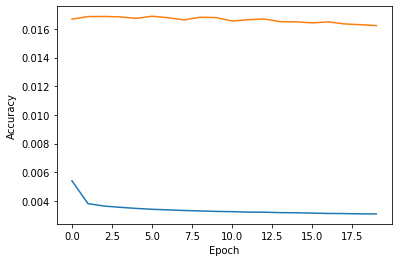

In [16]:
plt.plot(history.history['mae'], label='root_mean_squared_error')    #blue
plt.plot(history.history['val_mae'], label = 'val_root_mean_squared_error')     #orange
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [17]:
min(history.history['val_mae'])

0.016234698

In [18]:
predictions = model.predict(v.values[-20:])

### Run cibersort for comparison

In [19]:
c_results = td.cibersort_main(lm22,v.T)
c_results=c_results.T

Running CiberSort...


In [22]:
print("NN MAE:",mean_absolute_error(df.values[-20:],predictions))
print("CIBERSORT MAE:",mean_absolute_error(df.values[-20:],c_results.values[-20:]))

NN MAE: 0.016234696400662243
CIBERSORT MAE: 0.036199511590429785


In [23]:
nn_results = pd.DataFrame(data=predictions,columns=c_results.columns)
nn_results.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.061537,0.029059,0.072425,0.056827,0.028442,0.039231,0.059412,0.049213,0.038379,0.042503,...,0.049403,0.037171,0.039433,0.057987,0.061606,0.048674,0.032414,0.033645,0.039019,0.060699
1,0.047001,0.040696,0.028417,0.050123,0.047586,0.059507,0.046501,0.056975,0.057645,0.043581,...,0.048753,0.050402,0.026283,0.050317,0.050590,0.033431,0.030303,0.059191,0.039881,0.058544
2,0.045547,0.051965,0.028198,0.032042,0.055389,0.030362,0.025086,0.045900,0.042396,0.046049,...,0.051004,0.037177,0.037857,0.053964,0.058240,0.064473,0.056684,0.038393,0.041310,0.052078
3,0.045034,0.037833,0.033677,0.060382,0.047127,0.033322,0.029941,0.043791,0.055844,0.051504,...,0.050283,0.034636,0.049187,0.043191,0.035817,0.056924,0.042826,0.033041,0.057096,0.063003
4,0.030950,0.041977,0.035315,0.026077,0.056177,0.047118,0.031885,0.034521,0.042855,0.041896,...,0.029299,0.057479,0.049619,0.065704,0.050574,0.053882,0.062364,0.050765,0.053995,0.048440


### Make plots for comparison

C:\Users\NathanGrant\Programs\TripodsREU\scripts\TumorDecon\visualization.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df<0]=0
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


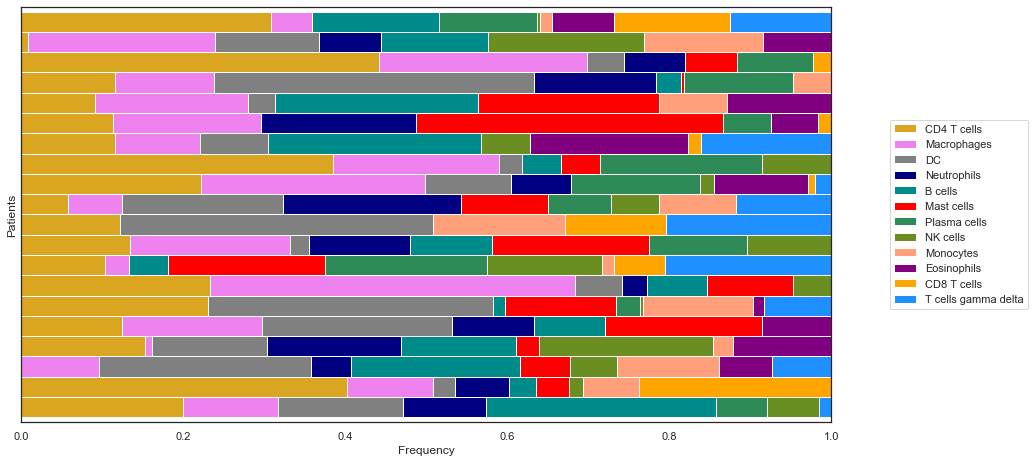

In [24]:
td.cell_frequency_barchart(c_results[-20:])

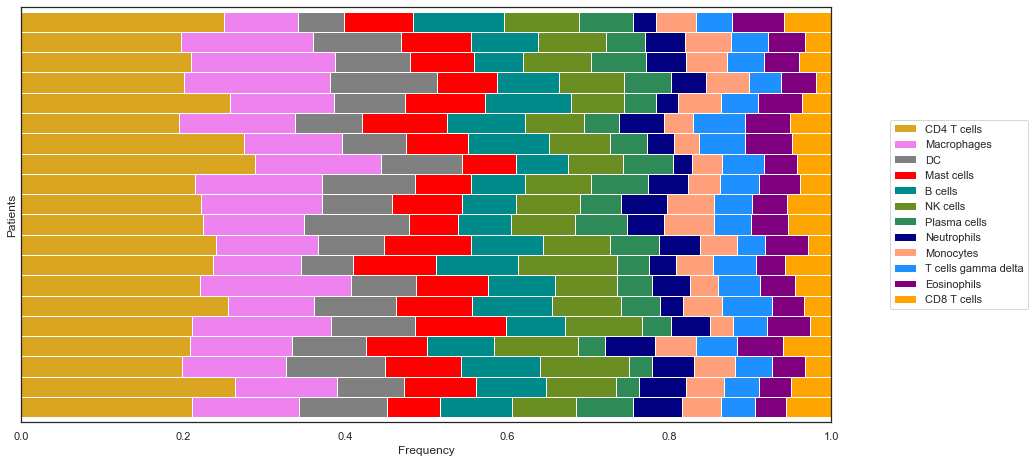

In [25]:
td.cell_frequency_barchart(nn_results)

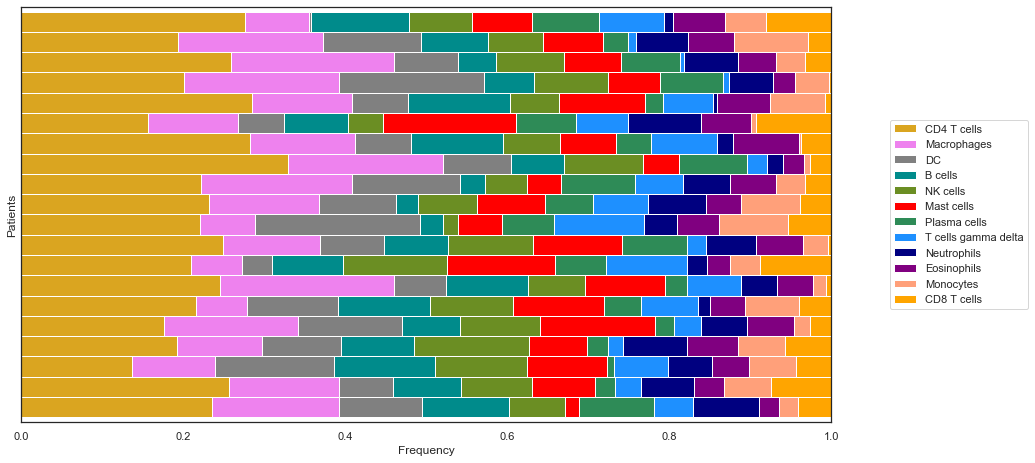

In [26]:
df.columns =c_results.columns
df.head()
td.cell_frequency_barchart(df.iloc[-20:])

### Find correlation between methods and ground truth

In [27]:
from scipy.stats import pearsonr
def compute_mean_cell_p_correlation(ground_truth,predicted):
    x=[]
    y=[]
    avg_sample = []
    for i in range(len(ground_truth)):
        avg_sample.append(pearsonr(ground_truth[i],predicted[i]))
    avg_cell_correlation = []
    for i in range(len(ground_truth[0])):
        avg_cell_correlation.append(pearsonr(ground_truth[:,i],predicted[:,i]))
    return np.mean(avg_sample),np.mean(avg_cell_correlation)

In [28]:
df_comb = td.combine_celltypes(df)
nn_results_comb = td.combine_celltypes(nn_results)
c_results_comb = td.combine_celltypes(c_results)

In [29]:
compute_mean_cell_p_correlation(df_comb.iloc[-20:].values,nn_results_comb.values)

(0.4655045225560531, 0.4094070320149182)

In [30]:
compute_mean_cell_p_correlation(df_comb.iloc[-20:].values,c_results_comb.iloc[-20:].values)

(0.3729943992546055, 0.3792319455435584)

### Make plots for data

0.933627793738503

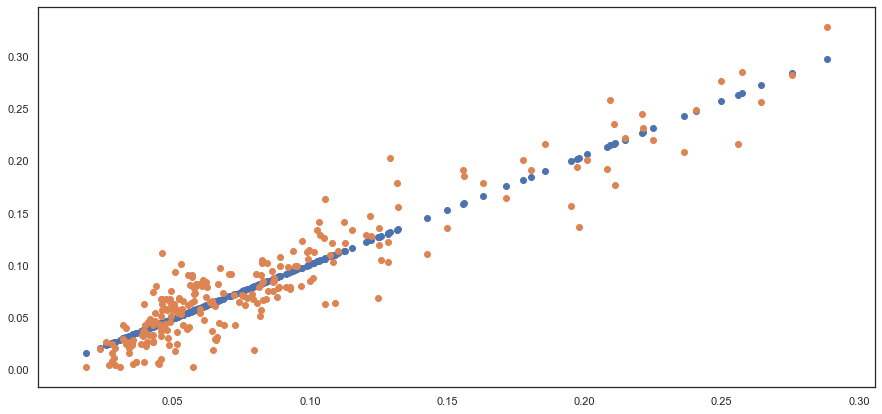

In [31]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(nn_results_comb.values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))
plt.scatter(nn_results_comb.values.flatten().reshape(-1, 1),lin.predict(nn_results_comb.values.flatten().reshape(-1, 1)))
plt.scatter(nn_results_comb.values,df_comb.iloc[-20:].values)
lin.score(nn_results_comb.values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))**.5

0.7086814215247145

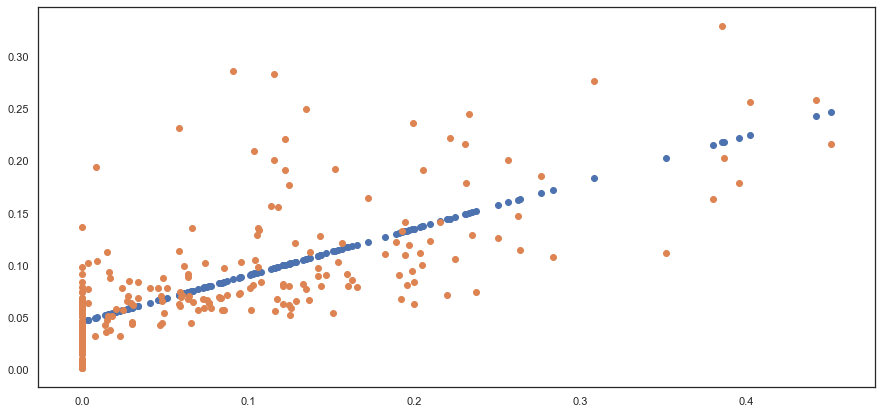

In [32]:
lin = LinearRegression().fit(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))
plt.scatter(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1),lin.predict(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1)))
plt.scatter(c_results_comb.iloc[-20:].values,df_comb.iloc[-20:].values)
lin.score(c_results_comb.iloc[-20:].values.flatten().reshape(-1, 1),df_comb.iloc[-20:].values.flatten().reshape(-1, 1))**.5

## Test on CIBERSORT ground truth data

In [56]:
cibersort_gep = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/ExampleMixtures-GEPs.txt",delimiter="\t",index_col="Hugo_Symbol")
cibersort_gep.head()

,Mix1,Mix2,Mix3,Mix4,Mix5
Hugo_Symbol,,,,,
A1CF,317.722091,293.341077,217.299844,324.780988,249.629992
A2M,151.455508,530.830854,837.158282,692.726721,2510.675378
A4GALT,73.512724,92.717987,64.725953,71.602486,81.679389
A4GNT,288.295490,259.639816,158.096971,282.407327,197.121171
AAAS,108.864797,106.834378,103.505401,50.651212,65.309679


In [57]:
cibersort_ground_truth = pd.read_csv("C:/Users/NathanGrant/Programs/TripodsREU/data/ExampleMixtures-GroundTruth.txt",delimiter="\t",header=None)
cibersort_ground_truth.columns = nn_results.columns
cibersort_ground_truth.head()

,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,...,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils
0,0.18,0.16,0.13,0.11,0.09,0.07,0.06,0.05,0.04,0.03,...,0.01,0.01,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00
1,0.20,0.00,0.19,0.00,0.18,0.00,0.10,0.00,0.09,0.00,...,0.05,0.00,0.04,0.00,0.04,0.00,0.02,0.00,0.02,0.00
2,0.00,0.00,0.01,0.01,0.01,0.02,0.03,0.05,0.07,0.11,...,0.11,0.07,0.05,0.03,0.02,0.01,0.01,0.01,0.00,0.00
3,0.17,0.12,0.08,0.06,0.03,0.02,0.01,0.00,0.00,0.00,...,0.00,0.00,0.00,0.01,0.02,0.03,0.06,0.08,0.12,0.17
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.04,...,0.02,0.04,0.09,0.11,0.08,0.05,0.04,0.07,0.14,0.20


In [60]:
c_normalized = encode_inputs(cibersort_gep,lm22)
c_normalized.shape

(5, 547)

In [66]:
predictions_2 = pd.DataFrame(data=model.predict(c_normalized.values),columns=c_results.columns)
cibersort_pred = td.cibersort_main(lm22,c_normalized.T)

Running CiberSort...


## Compare Plots

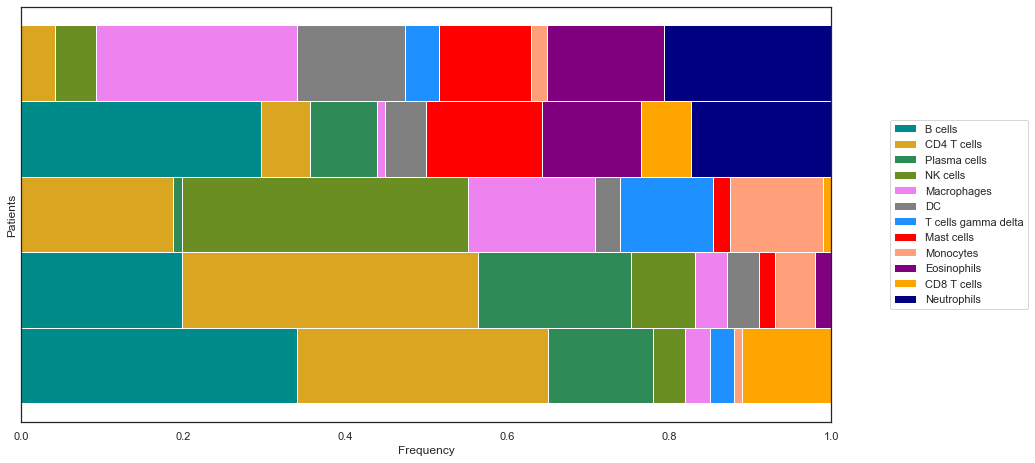

In [67]:
td.cell_frequency_barchart(cibersort_ground_truth)

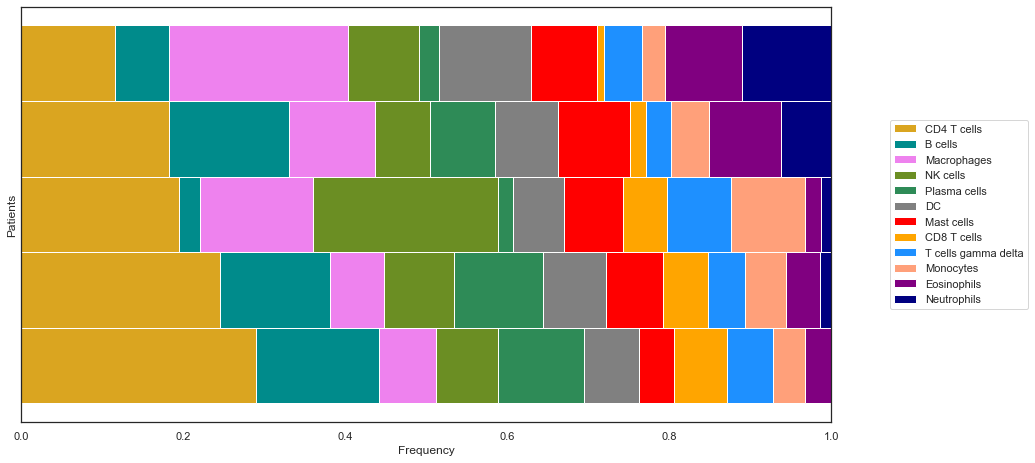

In [68]:
td.cell_frequency_barchart(predictions_2)

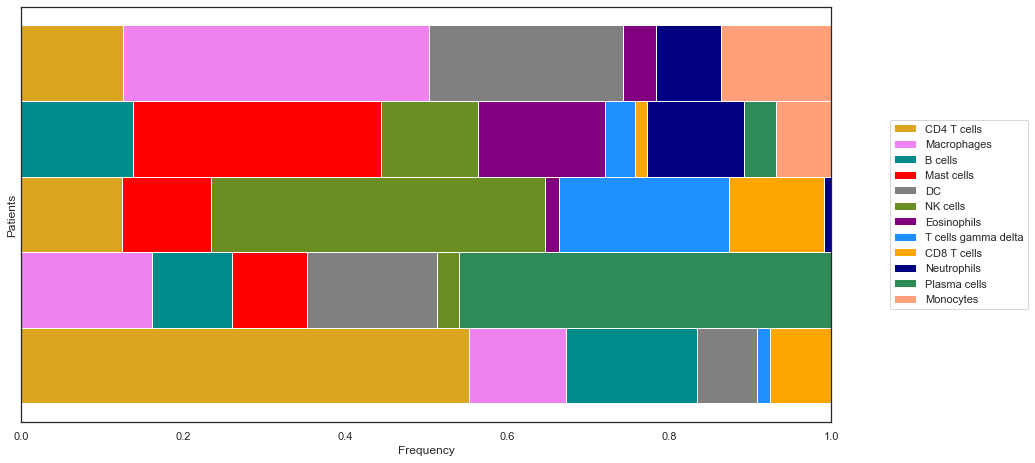

In [70]:
td.cell_frequency_barchart(cibersort_pred.T)

In [71]:
compute_mean_cell_p_correlation(cibersort_ground_truth.values,predictions_2.values)

(0.39480503401797246, 0.4605105292353808)

In [73]:
compute_mean_cell_p_correlation(cibersort_ground_truth.values,cibersort_pred.T.values)

(0.28166496861922957, 0.43127513907838094)

## Make Correlation Plots

0.7785946051652849

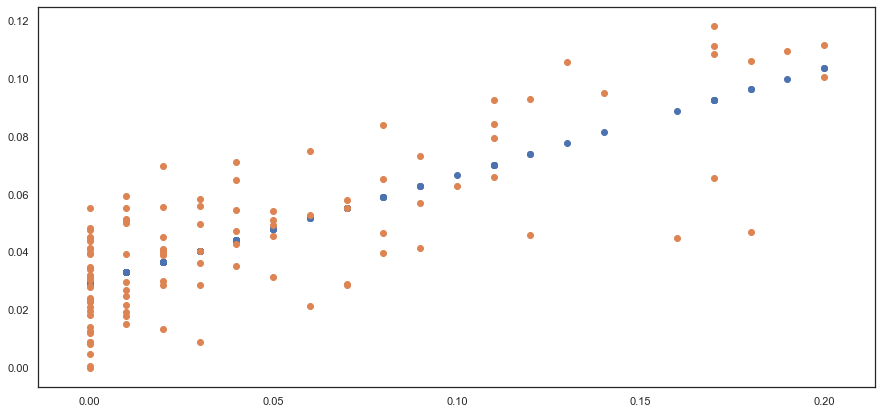

In [82]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression().fit(cibersort_ground_truth.values.flatten().reshape(-1, 1),predictions_2.values.flatten().reshape(-1, 1))
plt.scatter(cibersort_ground_truth.values.flatten().reshape(-1, 1),lin.predict(cibersort_ground_truth.values.flatten().reshape(-1, 1)))
plt.scatter(cibersort_ground_truth.values,predictions_2.values)
lin.score(cibersort_ground_truth.values.flatten().reshape(-1, 1),predictions_2.values.flatten().reshape(-1, 1))**.5

0.5031232728971158

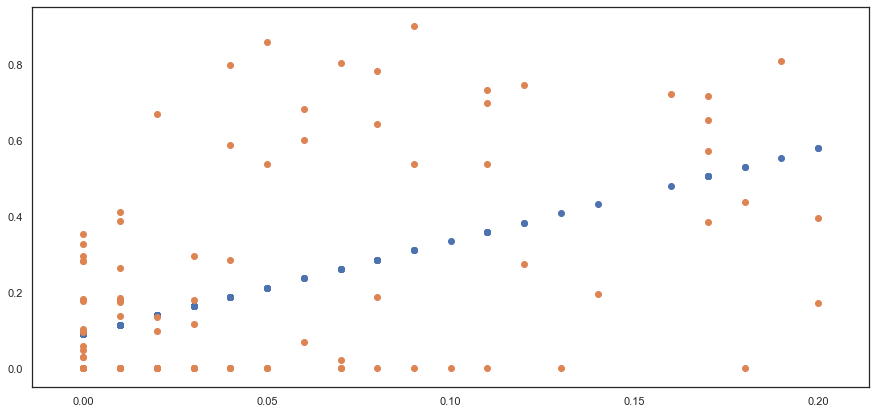

In [83]:
lin = LinearRegression().fit(cibersort_ground_truth.values.flatten().reshape(-1, 1),cibersort_pred.T.values.flatten().reshape(-1, 1))
plt.scatter(cibersort_ground_truth.values.flatten().reshape(-1, 1),lin.predict(cibersort_ground_truth.values.flatten().reshape(-1, 1)))
plt.scatter(cibersort_ground_truth.values,cibersort_pred.T.values)
lin.score(cibersort_ground_truth.values.flatten().reshape(-1, 1),cibersort_pred.T.values.flatten().reshape(-1, 1))**.5

In [86]:
print("NN MAE:",mean_absolute_error(cibersort_ground_truth.values,predictions_2.values))
print("CIBERSORT MAE:",mean_absolute_error(cibersort_ground_truth.values,cibersort_pred.T.values))

NN MAE: 0.03014007861709053
CIBERSORT MAE: 0.1824686514949728
